In [1]:
import numpy as np
import os
import configparser
import shutil

from keras import layers
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plotn
from keras.optimizers import SGD

from keras import models

from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from collections import OrderedDict


import sys
sys.path.insert(0, './lib_keras/')
from help_functions import *

from lib_keras.model_lib import *
#function to obtain data for training/testing (validation)
from extract_patches import get_data_training

print(K.tensorflow_backend._get_available_gpus())


Using TensorFlow backend.
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

['/job:localhost/replica:0/task:0/device:GPU:0']


In [24]:
temp = 11579
print(temp % 1156)

19


## custom U-net Model

### Load Configuration

In [2]:
config = configparser.RawConfigParser()
config.read('configuration.txt')
#patch to the datasets
path_data = config.get('data paths', 'path_local')
#Experiment name
save_folder = config.get('experiment name','result_save_path')
name_experiment = config.get('experiment name', 'name')

#training settings
num_epochs = int(config.get('training settings', 'num_epochs'))
batch_size = int(config.get('training settings', 'batch_size'))

print(' path data : {}\n save_folder : {}\n name_experiment : {}\n num_epoches : {}\n batch_size : {}\n'.format(path_data, save_folder,\
                                                                                                               name_experiment,\
                                                                                                               num_epochs,batch_size))
'''
5 class
class01 (255,0,0), Red , RNFL
class02 (0,255,0), Green, other layers
class03 (0,0,255), Blue, RPE
class04 (255,255,0), Yellow, LC

'''
mapping = OrderedDict()
mapping[(0,0,0)] = 0
mapping[(255,0,0)] = 1
mapping[(0,255,0)] = 2
mapping[(0,0,255)] = 3
mapping[(255,255,0)] = 4


print(mapping)
print(len(mapping))
print('./'+save_folder+'/'+name_experiment+'/')




 path data : ./data/hdf5_data/inha_oct_5classes/
 save_folder : result
 name_experiment : 09_no_contrast_64_Attn_notNaive_hybridTest
 num_epoches : 50
 batch_size : 8

OrderedDict([((0, 0, 0), 0), ((255, 0, 0), 1), ((0, 255, 0), 2), ((0, 0, 255), 3), ((255, 255, 0), 4)])
5
./result/09_no_contrast_64_Attn_notNaive_hybridTest/


In [3]:
if os.path.isdir('./'+save_folder+'/'+name_experiment+'/') == False:
    os.mkdir('./'+save_folder+'/'+name_experiment+'/')
else:
    print('already exist the folder in this path : {}'.format('./'+save_folder+'/'+name_experiment+'/'))

In [4]:
path_data + config.get('data paths', 'train_groundTruth')

# copy configuration

shutil.copyfile('./configuration.txt', './'+save_folder+'/'+name_experiment+'/configuration.txt')

'./result/09_no_contrast_64_Attn_notNaive_hybridTest/configuration.txt'

### Extract patch for training

In [5]:
print(' train path : {}\n train label path : {}\n patch height : {} patch width : {}\n\
 num subimgs : {} \t inside FOV : {} \t save path : {}'.format(path_data + config.get('data paths', 'train_imgs_original'),\
                                                       path_data + config.get('data paths', 'train_groundTruth'),\
                                                       int(config.get('data attributes', 'patch_height')),\
                                                       int(config.get('data attributes', 'patch_width')),\
                                                       int(config.get('training settings', 'num_subimgs')),\
                                                       config.getboolean('training settings', 'inside_FOV'),\
                                                       save_folder+'/'+name_experiment))

 train path : ./data/hdf5_data/inha_oct_5classes/inha_oct_5classes_train.hdf5
 train label path : ./data/hdf5_data/inha_oct_5classes/inha_oct_5classes_groundTruth_train.hdf5
 patch height : 64 patch width : 64
 num subimgs : 200000 	 inside FOV : False 	 save path : result/09_no_contrast_64_Attn_notNaive_hybridTest


In [6]:
patches_imgs_train, patches_masks_train, class_freq_tabel = get_data_training(
    train_imgs_original = path_data + config.get('data paths', 'train_imgs_original'),
    train_groudTruth = path_data + config.get('data paths', 'train_groundTruth'),  #masks
    patch_height = int(config.get('data attributes', 'patch_height')),
    patch_width = int(config.get('data attributes', 'patch_width')),
    num_subimgs = int(config.get('training settings', 'num_subimgs')),
    label_mapping = mapping,
    inside_FOV = config.getboolean('training settings', 'inside_FOV'), #select the patches only inside the FOV  (default == True)
    save_path = save_folder+'/'+name_experiment
)
print('Done!')

already exist the folder in this path : result/09_no_contrast_64_Attn_notNaive_hybridTest
number of subimages :  200000
[DEBUG] shape of train_imgs_original :  (40, 3, 500, 760)
[DEBUG] shape of train_imgs_label :  (40, 3, 500, 760)
[group images func] prev data shape  : (40, 3, 500, 760)
[group images func] after data shape :  (40, 500, 760, 3)
[group images func] first total image :  (500, 3800, 3)
[group images func] final total image :  (4500, 3800, 3)
data shape :  (4500, 3800, 3)
<PIL.Image.Image image mode=RGB size=3800x4500 at 0x7F77D0C9E320>
file name :  ./result/09_no_contrast_64_Attn_notNaive_hybridTest/imgs_train
[group images func] prev data shape  : (40, 3, 500, 760)
[group images func] after data shape :  (40, 500, 760, 3)
[group images func] first total image :  (500, 3800, 3)
[group images func] final total image :  (4500, 3800, 3)
data shape :  (4500, 3800, 3)
<PIL.Image.Image image mode=RGB size=3800x4500 at 0x7F77D0C9E320>
file name :  ./result/09_no_contrast_64_Att

extract patches:   0%|          | 0/40 [00:00<?, ?it/s]



[final pad] imgs shape : (40, 512, 768, 1)	 labels shape : (40, 512, 768, 3)


[final transpose] imgs shape : (40, 1, 512, 768)	 labels shape : (40, 3, 512, 768)


[get_data_training] train images/masks shape : (40, 1, 512, 768)
[get_data_training] train images range (min-max) [0.0 , 1.0] 
[get_data_training] train masks are within 0-1



[extract random] num of class :  5
[extract random] full image shape : (40, 1, 512, 768)
[extract random] full masks shape : (40, 3, 512, 768)
[extract random] patches shape : (200000, 1, 64, 64)
[extract random] patches masks shape : (200000, 5, 64, 64)
[extract random] patches per full image : 5000


extract patches: 100%|██████████| 40/40 [07:46<00:00, 11.66s/it]


[After patch] mask shape :  (200000, 5, 64, 64)
[Augmentation function] patches shape :  (200000, 1, 64, 64)
[Augmentation function] augmentation patches shape :  (200000, 64, 64, 1)
[Augmentation function] augmentation patches masks shape :  (200000, 64, 64, 5)


[get_data_training] train PATCHES images/masks shape : (200000, 1, 64, 64)
[get_data_training] train PATCHES images range (min-max): 0.0 - 1.0
[get_data_training] patches_imgs_train : (200000, 1, 64, 64)
[group images func] prev data shape  : (50, 1, 64, 64)
[group images func] after data shape :  (50, 64, 64, 1)
[group images func] first total image :  (64, 320, 1)
[group images func] final total image :  (704, 320, 1)
data shape :  (704, 320, 1)
<PIL.Image.Image image mode=L size=320x704 at 0x7F77D01EED68>
file name :  ./result/09_no_contrast_64_Attn_notNaive_hybridTest/train_patch_img
Done!


In [ ]:
#class_freq_tabel 

class_freq_tabel['frequency_0'] = class_freq_tabel['class_0'] / (class_freq_tabel['frequency_0'] * (64*64))
class_freq_tabel['frequency_1'] = class_freq_tabel['class_1'] / (class_freq_tabel['frequency_1'] * (64*64))
class_freq_tabel['frequency_2'] = class_freq_tabel['class_2'] / (class_freq_tabel['frequency_2'] * (64*64))
class_freq_tabel['frequency_3'] = class_freq_tabel['class_3'] / (class_freq_tabel['frequency_3'] * (64*64))
class_freq_tabel['frequency_4'] = class_freq_tabel['class_4'] / (class_freq_tabel['frequency_4'] * (64*64))


#df = pd.DataFrame()
#df['']


In [7]:
class_freq_tabel



,class_0,class_1,class_2,class_3,class_4,frequency_0,frequency_1,frequency_2,frequency_3,frequency_4
0,17448586,833468,1236180,361563,600203,0.851982,0.0406967,0.0603604,0.0176544,0.0293068
1,16344932,1465679,1611246,354105,704038,0.798092,0.0715664,0.0786741,0.0172903,0.0343769
2,16308644,1950908,1073159,309579,837710,0.796321,0.0952592,0.0524003,0.0151162,0.0409038
3,16513670,1580175,1375593,363730,646832,0.806332,0.077157,0.0671676,0.0177603,0.0315836
4,16180743,1368451,1936633,369123,625050,0.790075,0.0668189,0.0945622,0.0180236,0.03052
5,16405506,1912908,1411984,359261,390341,0.80105,0.0934037,0.0689445,0.017542,0.0190596
6,17382997,1537100,944199,319895,295809,0.848779,0.0750537,0.0461035,0.0156199,0.0144438
7,16848405,1048581,1843015,387345,352654,0.822676,0.0512002,0.089991,0.0189133,0.0172194
8,17113817,1231636,1441430,428188,264929,0.835636,0.0601385,0.0703823,0.0209076,0.012936
9,17189934,1386271,1286013,392786,224996,0.839352,0.067689,0.0627936,0.019179,0.0109861


In [8]:
import pandas as pd

average_class_freq = pd.DataFrame(columns=['avg_class_00', 'avg_class_01', 'avg_class_02','avg_class_03','avg_class_04', 'avg_freq_00','avg_freq_01','avg_freq_02','avg_freq_03','avg_freq_04'])

average_class_freq.loc[0,'avg_class_00'] = class_freq_tabel['class_0'].mean()
average_class_freq.loc[0,'avg_class_01'] = class_freq_tabel['class_1'].mean()
average_class_freq.loc[0,'avg_class_02'] = class_freq_tabel['class_2'].mean()
average_class_freq.loc[0,'avg_class_03'] = class_freq_tabel['class_3'].mean()
average_class_freq.loc[0,'avg_class_04'] = class_freq_tabel['class_4'].mean()

average_class_freq.loc[0,'avg_freq_00'] = class_freq_tabel['frequency_0'].mean()
average_class_freq.loc[0,'avg_freq_01'] = class_freq_tabel['frequency_1'].mean()
average_class_freq.loc[0,'avg_freq_02'] = class_freq_tabel['frequency_2'].mean()
average_class_freq.loc[0,'avg_freq_03'] = class_freq_tabel['frequency_3'].mean()
average_class_freq.loc[0,'avg_freq_04'] = class_freq_tabel['frequency_4'].mean()

average_class_freq

,avg_class_00,avg_class_01,avg_class_02,avg_class_03,avg_class_04,avg_freq_00,avg_freq_01,avg_freq_02,avg_freq_03,avg_freq_04
0,1.65588e+07,1.70063e+06,1.35526e+06,387377,477983,0.808533,0.0830383,0.0661748,0.0189149,0.023339


In [9]:
class_freq_tabel.to_csv('./'+save_folder+'/'+name_experiment+'/'+'all_class_imbalance.csv', encoding='utf-8')
average_class_freq.to_csv('./'+save_folder+'/'+name_experiment+'/'+'avg_class_imbalance.csv', encoding='utf-8')


In [10]:

patches_masks_train_class00 = patches_masks_train[:,0,:,:] 
patches_masks_train_class00 = np.expand_dims(patches_masks_train_class00,1)
patches_masks_train_class01 = patches_masks_train[:,1,:,:] 
patches_masks_train_class01 = np.expand_dims(patches_masks_train_class01,1)
patches_masks_train_class02 = patches_masks_train[:,2,:,:] 
patches_masks_train_class02 = np.expand_dims(patches_masks_train_class02,1)
patches_masks_train_class03 = patches_masks_train[:,3,:,:] 
patches_masks_train_class03 = np.expand_dims(patches_masks_train_class03,1)
patches_masks_train_class04 = patches_masks_train[:,4,:,:] 
patches_masks_train_class04 = np.expand_dims(patches_masks_train_class04,1)


print(np.shape(patches_masks_train_class00))

(200000, 1, 64, 64)


### Visualizing

[group images func] prev data shape  : (40, 1, 64, 64)
[group images func] after data shape :  (40, 64, 64, 1)
[group images func] first total image :  (64, 320, 1)
[group images func] final total image :  (576, 320, 1)
data shape :  (576, 320, 1)
<PIL.Image.Image image mode=L size=320x576 at 0x7F77D019C5C0>
file name :  ./result/09_no_contrast_64_Attn_notNaive_hybridTest/sample_input_imgs
[group images func] prev data shape  : (40, 1, 64, 64)
[group images func] after data shape :  (40, 64, 64, 1)
[group images func] first total image :  (64, 320, 1)
[group images func] final total image :  (576, 320, 1)
data shape :  (576, 320, 1)
<PIL.Image.Image image mode=L size=320x576 at 0x7F77D019C550>
file name :  ./result/09_no_contrast_64_Attn_notNaive_hybridTest/sample_input_masks_claass0
[group images func] prev data shape  : (40, 1, 64, 64)
[group images func] after data shape :  (40, 64, 64, 1)
[group images func] first total image :  (64, 320, 1)
[group images func] final total image : 

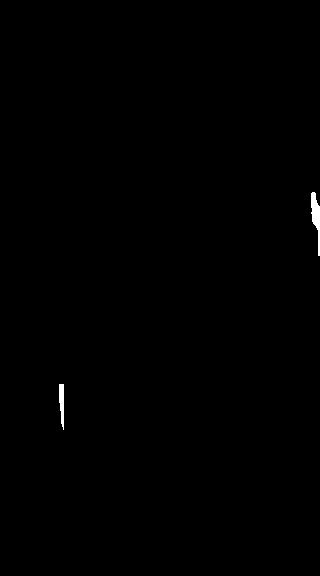

In [11]:
N_sample = min(patches_imgs_train.shape[0],40)
visualize(group_images(patches_imgs_train[0:N_sample,:,:,:],5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_imgs")#.show()
visualize(group_images(patches_masks_train_class00[0:N_sample,:,:,:],5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_masks_claass0")#.show()
visualize(group_images(patches_masks_train_class01[0:N_sample,:,:,:],5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_masks_claass1")#.show()
visualize(group_images(patches_masks_train_class02[0:N_sample,:,:,:],5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_masks_claass2")#.show()
visualize(group_images(patches_masks_train_class03[0:N_sample,:,:,:],5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_masks_claass3")#.show()
visualize(group_images(patches_masks_train_class04[0:N_sample,:,:,:],5),'./'+save_folder+'/'+name_experiment+'/'+"sample_input_masks_claass4")#.show()

### Model fitting

In [12]:
n_ch = patches_imgs_train.shape[1]
patch_height = patches_imgs_train.shape[2]
patch_width = patches_imgs_train.shape[3]
print('shape : ',patches_imgs_train.shape)
print('n_ch : {} patch_h : {} patch_w : {}'.format(n_ch, patch_height, patch_width))
#model = naive_attn_unet(n_ch, patch_height, patch_width)  #the U-net model
#model = unet_norm(n_ch, patch_height, patch_width,len(mapping))
#model = naive_attn_unet(n_ch, patch_height, patch_width,len(mapping))

#model = bigger_unet_norm(n_ch, patch_height, patch_width,len(mapping))
#model = bigger_naive_attn_unet(n_ch, patch_height, patch_width,len(mapping))
model = attn_unet(n_ch, patch_height, patch_width,len(mapping))
#model = attn_reg_test(n_ch, patch_height, patch_width,len(mapping))

print ("Check: final output of the network:")
print (model.output_shape)

#plot(model, to_file= './'+save_folder+'/'+name_experiment+'/' +name_experiment+ '_model.png')   #check how the model looks like
#plot(model, to_file= name_experiment+'/'+name_experiment + '_model.png')   #check how the model looks like

json_string = model.to_json()
open('./'+save_folder+'/'+name_experiment+'/' +name_experiment+'_architecture.json', 'w').write(json_string)


shape :  (200000, 1, 64, 64)
n_ch : 1 patch_h : 64 patch_w : 64
input shape :  (None, 1, 64, 64)

gating shape : (None, 128, 4, 4), conv4 shape : (None, 64, 8, 8)
shape x,g  (None, 64, 8, 8) (None, 128, 4, 4)
inter shape :   128
stride x : 1 stride y : 1
theta_x shape :  (None, 128, 4, 4)
upsample_g shape :  (None, 128, 4, 4)

attn1 shape : (None, 64, 8, 8) center shape : (None, 128, 4, 4) 

attn1 shape : (None, 64, 8, 8) up1 shape : (None, 128, 8, 8)
shape x,g  (None, 64, 16, 16) (None, 128, 8, 8)
inter shape :   64
stride x : 1 stride y : 1
theta_x shape :  (None, 64, 8, 8)
upsample_g shape :  (None, 64, 8, 8)
shape x,g  (None, 32, 32, 32) (None, 128, 16, 16)
inter shape :   64
stride x : 1 stride y : 1
theta_x shape :  (None, 64, 16, 16)
upsample_g shape :  (None, 64, 16, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (Inp

41736

### Training Session

In [13]:
'''
Keras provides a set of functions called callbacks: 
you can think of callbacks as events that will be triggered at certain training states. 
The callback we need for checkpointing is the ModelCheckpoint 
which provides all the features we need according to the checkpointing strategy we adopted in our example
'''

checkpointer = ModelCheckpoint(filepath='./'+save_folder+'/'+name_experiment+'/best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decreased

print('[training session] mask unet func patch mask shape :q ',patches_masks_train.shape)
patches_masks_train = np.reshape(patches_masks_train, (patches_masks_train.shape[0], len(mapping), patch_height* patch_width))
patches_masks_train = np.transpose(patches_masks_train,(0,2,1))
#patches_masks_train = masks_Unet(patches_masks_train)  #reduce memory consumption
print('[training session] After mask unet func patch mask shape : ',patches_masks_train.shape)






[training session] mask unet func patch mask shape :q  (200000, 5, 64, 64)
[training session] After mask unet func patch mask shape :  (200000, 4096, 5)


In [14]:
try:
    history = model.fit(patches_imgs_train, patches_masks_train, epochs=num_epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_split=0.2, callbacks=[checkpointer])
    model.save_weights('./'+save_folder+'/'+name_experiment +'/last_weights.h5', overwrite=False)
except KeyboardInterrupt:
    model.save_weights('./'+save_folder+'/'+name_experiment +'/last_weights.h5', overwrite=False)
    print('Keyboard Interrupt')

Train on 160000 samples, validate on 40000 samples
Epoch 1/50
160000/160000 [==============================] - 1850s 12ms/step - loss: 38.1978 - acc: 0.8585 - val_loss: 30.3643 - val_acc: 0.8899

Epoch 00001: val_loss improved from inf to 30.36429, saving model to ./result/09_no_contrast_64_Attn_notNaive_hybridTest/best_weights.h5
Epoch 2/50
160000/160000 [==============================] - 1711s 11ms/step - loss: 20.9866 - acc: 0.9188 - val_loss: 19.9273 - val_acc: 0.9256

Epoch 00002: val_loss improved from 30.36429 to 19.92726, saving model to ./result/09_no_contrast_64_Attn_notNaive_hybridTest/best_weights.h5
Epoch 3/50
160000/160000 [==============================] - 1818s 11ms/step - loss: 15.2500 - acc: 0.9386 - val_loss: 16.0494 - val_acc: 0.9363

Epoch 00003: val_loss improved from 19.92726 to 16.04942, saving model to ./result/09_no_contrast_64_Attn_notNaive_hybridTest/best_weights.h5
Epoch 4/50
160000/160000 [==============================] - 1724s 11ms/step - loss: 13.1729 -

In [ ]:
history = model.fit(patches_imgs_train, patches_masks_train, epochs=num_epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_split=0.2, callbacks=[checkpointer])
model.save_weights('./'+save_folder+'/'+name_experiment +'/last_weights.h5', overwrite=False)

In [ ]:
'''
Keras provides a set of functions called callbacks: 
you can think of callbacks as events that will be triggered at certain training states. 
The callback we need for checkpointing is the ModelCheckpoint 
which provides all the features we need according to the checkpointing strategy we adopted in our example


checkpointer = ModelCheckpoint(filepath='./'+save_folder+'/'+name_experiment+'/best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decreased

print('[training session] before mask unet func patch mask shape : ',patches_masks_train.shape)
patches_masks_train = masks_Unet(patches_masks_train)  #reduce memory consumption
print('[training session] after mask unet func patch mask shape : ',patches_masks_train.shape)

#print(len(x_train))
history = model.fit_generator(data_gen.flow(patches_imgs_train,patches_masks_train,batch_size=batch_size,subset='training'), 
                              steps_per_epoch=len(patches_imgs_train)/batch_size,epochs=num_epochs, verbose=1,shuffle=True, callbacks=[checkpointer],
                             validation_data = data_gen.flow(patches_imgs_train,patches_masks_train,batch_size=batch_size,subset='validation'),
                             validation_steps = 10)
model.save_weights('./'+save_folder+'/'+name_experiment +'/last_weights.h5', overwrite=True) '''


dict_keys(['loss', 'val_loss', 'acc', 'val_acc'])


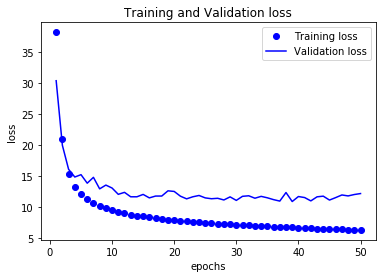

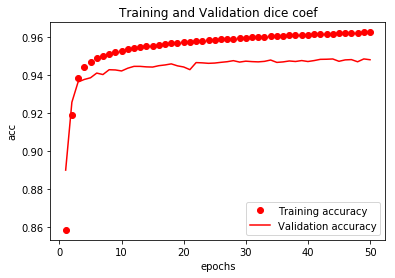

already exist the folder in this path : ./result/09_no_contrast_64_Attn_notNaive_hybridTest/train_history
already exist the folder in this path : ./result/09_no_contrast_64_Attn_notNaive_hybridTest/train_history
already exist the folder in this path : ./result/09_no_contrast_64_Attn_notNaive_hybridTest/train_history


In [15]:
import matplotlib.pyplot as plt

print(history.history.keys())

loss = history.history['loss']
val_loss= history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1,len(acc) +1)

plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("epochs")
plt.ylabel('loss')
plt.legend()
plt.savefig('./'+save_folder+'/'+name_experiment+"/training_loss_result.png")
plt.figure()

plt.plot(epochs, acc, 'ro', label = "Training accuracy")
plt.plot(epochs, val_acc, 'r', label = "Validation accuracy")
plt.title("Training and Validation dice coef")
plt.xlabel("epochs")
plt.ylabel('acc')
plt.legend()


plt.savefig('./'+save_folder+'/'+name_experiment+"/training_acc_result.png")
plt.show()

import pandas as pd
file_path = './'+save_folder+'/'+name_experiment + '/' + 'train_history'

def save_history_txt_csv(history, file_path, file_name):
    if os.path.isdir(file_path) == False:
        os.mkdir(file_path)
    else:
        print('already exist the folder in this path : {}'.format(file_path))
    
    hist_df = pd.DataFrame(history) 

    # save to json:  
    hist_json_file = file_path + '/' + file_name +'.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = file_path + '/' + file_name + '.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        

save_history_txt_csv(loss, file_path, 'train_loss')
save_history_txt_csv(val_loss, file_path, 'val_loss')
save_history_txt_csv(acc, file_path, 'train_acc')
save_history_txt_csv(val_acc, file_path, 'val_acc')

In [ ]:
import pandas as pd
file_path = './'+save_folder+'/'+name_experiment + '/' + 'train_history'

def save_history_txt_csv(history, file_path, file_name):
    if os.path.isdir(file_path) == False:
        os.mkdir(file_path)
    else:
        print('already exist the folder in this path : {}'.format(file_path))
    
    hist_df = pd.DataFrame(history) 

    # save to json:  
    hist_json_file = file_path + '/' + file_name +'.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = file_path + '/' + file_name + '.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        

save_history_txt_csv(loss, file_path, 'train_loss')
save_history_txt_csv(val_loss, file_path, 'val_loss')
save_history_txt_csv(acc, file_path, 'train_acc')
save_history_txt_csv(val_acc, file_path, 'val_acc')

## 

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())

loss = history.history['loss']
val_loss= history.history['val_loss']
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

epochs = range(1,len(acc) +1)

plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("epochs")
plt.ylabel('loss')
plt.legend()
plt.savefig('./'+save_folder+'/'+name_experiment+"/training_loss_result.png")
plt.figure()

plt.plot(epochs, acc, 'ro', label = "Training dice coef")
plt.plot(epochs, val_acc, 'r', label = "Validation dice coef")
plt.title("Training and Validation dice coef")
plt.xlabel("epochs")
plt.ylabel('acc')
plt.legend()


plt.savefig('./'+save_folder+'/'+name_experiment+"/training_acc_result.png")
plt.show()